# GLASS Covariance Challenge

In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import glass
import glass.ext.camb
import heracles

In [2]:
def plot_spectra(*spectra, labels=[], log=True):
    nspec = max(len(cls) for cls in spectra)
    nfields = glass.fields.inv_triangle_number(nspec)
    fig, ax = plt.subplots(
        nfields, nfields, figsize=(1.1 * nfields, 1.0 * nfields), sharex=True, sharey=True, layout="constrained",
    )

    for (i, j), *spec in zip(glass.spectra_indices(nfields), *spectra):
        ax[i, j].tick_params(axis="both", which="both", direction="in")
        for c, cl in enumerate(spec):
            if log:
                ax[i, j].plot(np.arange(1, cl.size), +cl[1:], alpha=0.5, c=f"C{c}")
                ax[i, j].plot(np.arange(1, cl.size), -cl[1:], alpha=0.5, c=f"C{c}", ls="--")
            else:
                ax[i, j].plot(np.arange(cl.size), cl, alpha=0.5, c=f"C{c}")

    for i, j in zip(*np.triu_indices(nfields, 1)):
        ax[i, j].axis("off")

    ax[0, 1].legend(
        handles=[
            plt.Line2D([0], [0], c=f"C{c}", label=label) for c, label in enumerate(labels)
        ],
        loc="lower left",
        frameon=False,
        fontsize=6,
        borderpad=0.0,
        borderaxespad=0.0,
    )

    if log:
        ax[0, 0].set_xscale("log")
        ax[0, 0].set_yscale("log")

    return fig, ax

### Make N(z)

In [3]:
z = np.arange(0.0, 5.01, 0.01)

dndz = glass.smail_nz(z, 1.0, 1.5, 2.0)

nbins = 4
zbins = glass.equal_dens_zbins(z, dndz, nbins)

nz = glass.tomo_nz_gausserr(z, dndz, 0.05, zbins)

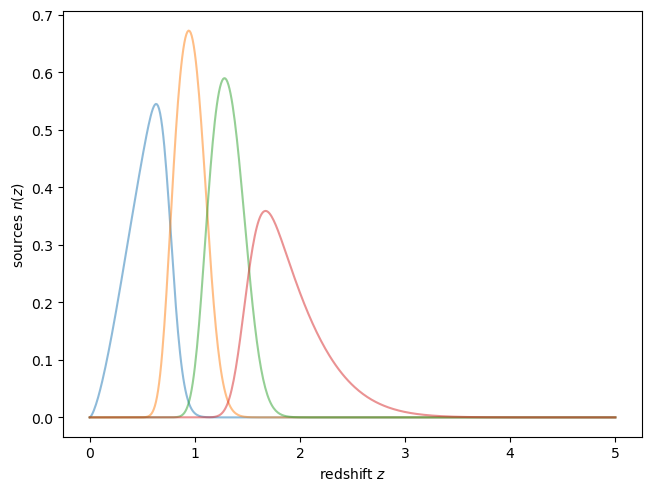

In [4]:
plt.figure(layout="constrained")
plt.plot(z, nz.T, alpha=0.5)
plt.xlabel("redshift $z$")
plt.ylabel("sources $n(z)$")
plt.show()

In [5]:
# density
nz_1 = nz[:2]

# convergence
nz_2 = nz[2:]

### Make Theory Cls

In [6]:


rng = np.random.default_rng(seed=42)

h = 0.7
Oc = 0.25
Ob = 0.05

nside = lmax = 256

pars = camb.set_params(
    H0=100 * h,
    omch2=Oc * h**2,
    ombh2=Ob * h**2,
    NonLinear=camb.model.NonLinear_both,
)

pars.set_accuracy(AccuracyBoost=2.0, lAccuracyBoost=2.0, lSampleBoost=2.0)
pars.Want_CMB = False
pars.Want_CMB_lensing = False
pars.min_l = 1
pars.set_for_lmax(2 * lmax)

pars.SourceWindows = [
    camb.sources.SplinedSourceWindow(z=z, W=nz_i, source_type="counts") for nz_i in nz_1
] + [
    camb.sources.SplinedSourceWindow(z=z, W=nz_i, source_type="lensing") for nz_i in nz_2
]

cls_dict = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)
cls = [cls_dict[f"W{i+1}xW{j+1}"] for i, j in glass.spectra_indices(nbins)]

NameError: name 'camb' is not defined

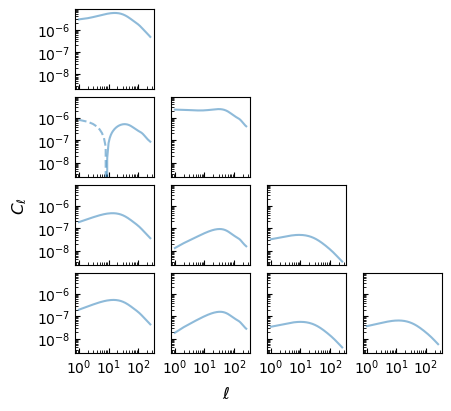

In [ ]:
fig, ax = plot_spectra(cls)
fig.supxlabel("$\\ell$")
fig.supylabel("$C_\\ell$")

plt.show()

### GLASS Shells

In [ ]:
shells_1 = [
    glass.RadialWindow(z, nz_i, np.trapezoid(z * nz_i, z) / np.trapezoid(nz_i, z)) for nz_i in nz_1
]
shells_2 = [
    glass.RadialWindow(z, nz_i, np.trapezoid(z * nz_i, z) / np.trapezoid(nz_i, z)) for nz_i in nz_2
]

In [ ]:
# density
fields_1 = glass.lognormal_fields(shells_1)
#fields_1 = glass.gaussian_fields(shells_1)

# convergence
fields_2 = glass.lognormal_fields(shells_2, glass.lognormal_shift_hilbert2011)
#fields_2 = glass.gaussian_fields(shells_2)

In [ ]:
fields = fields_1 + fields_2
gls = glass.solve_gaussian_spectra(fields, cls)
# We must regularize
gls = glass.regularized_spectra(gls)

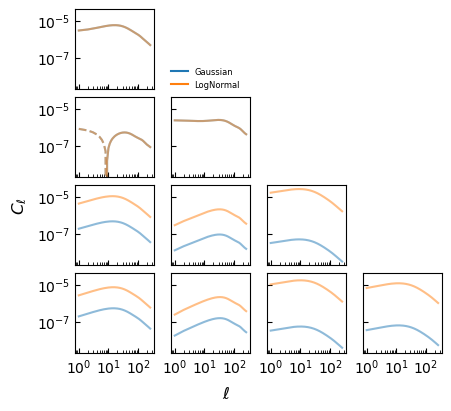

In [ ]:
fig, ax = plot_spectra(cls, gls, labels=["Gaussian", "LogNormal"])

fig.supxlabel("$\\ell$")
fig.supylabel("$C_\\ell$")

plt.show()



### Simulate Maps

In [ ]:
maps = list(glass.generate(fields, gls, nside))

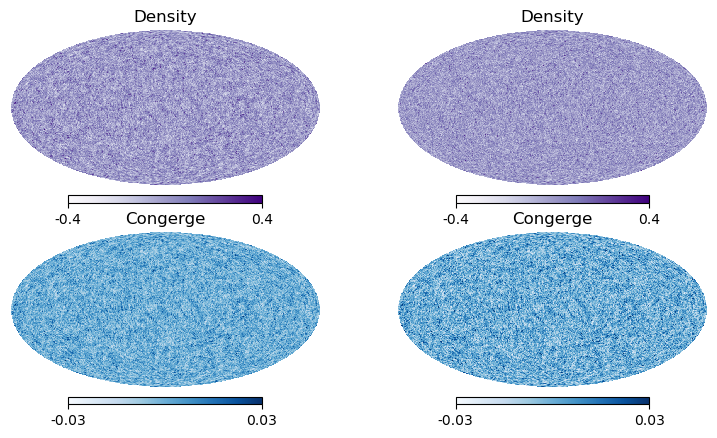

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
fig.subplots_adjust(hspace=0.1, wspace=0.0)

for i, m in enumerate(maps[:2]):
    plt.sca(ax[0, i])
    hp.mollview(m, title="Density", hold=True, cmap="Purples", min=-0.4, max=0.4)

for i, m in enumerate(maps[2:]):
    plt.sca(ax[1, i])
    hp.mollview(m, title="Congerge", hold=True, cmap="Blues", min=-0.03, max=0.03)

plt.show()

### Measure Cls

In [ ]:
cls_sim = hp.anafast(maps, lmax=lmax, pol=False, use_pixel_weights=True)
# reorder spectra from HEALPix to GLASS order
cls_sim = glass.healpix_to_glass_spectra(cls_sim)

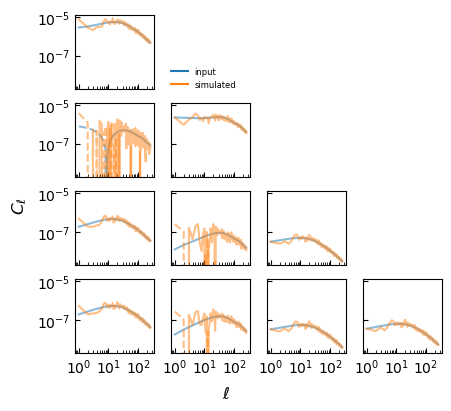

In [ ]:
fig, ax = plot_spectra(cls, cls_sim, labels=["input", "simulated"])

fig.supxlabel("$\\ell$")
fig.supylabel("$C_\\ell$")

plt.show()